In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyfuncs.utils import load_nodes_map, load_genes_map, map_node_name

In [34]:
# Load data
sample = np.abs(np.loadtxt("Data/sample.txt")).T
# Frequencies
frequencies = sample.mean(axis=0)
# Cancer sample idx
cancer_idx = np.loadtxt('Data/cancer_sample.txt', dtype=int) - 1
cancer_sample = sample[cancer_idx, :]
# Normal sample idx
normal_idx = np.ones(sample.shape[0], dtype=bool)
normal_idx[cancer_idx] = 0
normal_sample = sample[normal_idx, :]
# Compressed nodes dict
compressed_nodes_map = load_nodes_map("Data/nodes.txt")
# Genes names maps
genes_map = load_genes_map("Data/names.txt")
# Brownian sample
brownian_sample = np.loadtxt('result_files/brownian_sample.txt').astype(int)
brownian_cancer_sample = brownian_sample[cancer_idx, :]
# Load graph
Graph = nx.read_adjlist('Data/gene_network.adjlist', create_using=nx.DiGraph, nodetype=int)
# Import genecards PRAD genes
prad_genecards = pd.read_csv('Data/GeneCards-PRAD.csv').iloc[:, [0, 5]]

# x, y = np.unique(brownian_sample.sum(axis=1), return_counts=True)
# y = y / brownian_sample.shape[0]
brownian_sample.shape, brownian_cancer_sample.shape

((551, 46923), (499, 46923))

In [35]:
# gen = 4205
# for i in range(len(compressed_nodes_map)):
#     if gen in compressed_nodes_map[i]:
#         break

# print(f'Gen: {gen}, Nodo: {i}, Name: {map_node_name(i, compressed_nodes_map, genes_map)[0]}')

In [36]:

prad_genecards.head()

,Gene Symbol,Relevance score
0,BRCA2,365.828125
1,BRCA1,333.097870
2,CHEK2,250.115540
3,TP53,243.543457
4,CDH1,235.463699


# Establish gene concepts

In [37]:
concepts = ['None'] * sample.shape[1]

normal_concept = np.where(normal_sample.mean(axis=0) == 0)[0]
#cancer_concept = np.where(cancer_sample.mean(axis=0) > .9)[0]

for i in normal_concept:
    concepts[i] = 'Normal'

# for i in cancer_concept:
#     concepts[i] = 'Cancer'

concepts = np.array(concepts)

# Identify chain starts

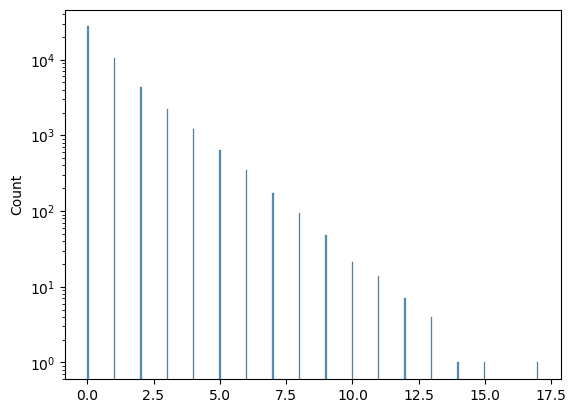

In [38]:
sns.histplot(brownian_cancer_sample.sum(axis=0))
plt.yscale('log')

In [39]:
chain_starts = np.where(brownian_cancer_sample.sum(axis=0) > 0)[0]
starts_freqs = brownian_cancer_sample.sum(axis=0)[chain_starts] / brownian_cancer_sample.shape[0]
ordered_idx = np.argsort(starts_freqs)[::-1]
chain_starts, starts_freqs = chain_starts[ordered_idx], starts_freqs[ordered_idx]

In [40]:
# Save chain starts 
chain_heads = []
max_compressed_frequency = True

with open('result_files/brownian_cancer_starts', 'w') as file:
    for node, freq in zip(chain_starts, starts_freqs):
        nodes = compressed_nodes_map[node]
        chain_heads.append(nodes)
        if len(nodes) > 1 and max_compressed_frequency:
            print('Ngenes: ', len(nodes), '\tNsamples: ', round(freq * brownian_cancer_sample.shape[0]))
            max_compressed_frequency = False
        line = f'{freq:.3}\t'
        for gene in nodes:
            line = line + genes_map[gene] + '\t'
        line = line + '\n'
        file.write(line)

Ngenes:  2 	Nsamples:  1


# Number of dysregulated genes

In [41]:
# Cancer dysregulated sample
dysregulated_cancer = np.zeros_like(cancer_sample)
for i in range(dysregulated_cancer.shape[0]):
    for j in range(dysregulated_cancer.shape[1]):
        if cancer_sample[i, j] == 1:
            dysregulated_cancer[i, j] = len(compressed_nodes_map[j])

# Normal dysregulated sample
dysregulated_normal = np.zeros_like(normal_sample)
for i in range(dysregulated_normal.shape[0]):
    for j in range(dysregulated_normal.shape[1]):
        if normal_sample[i, j] == 1:
            dysregulated_normal[i, j] = len(compressed_nodes_map[j])

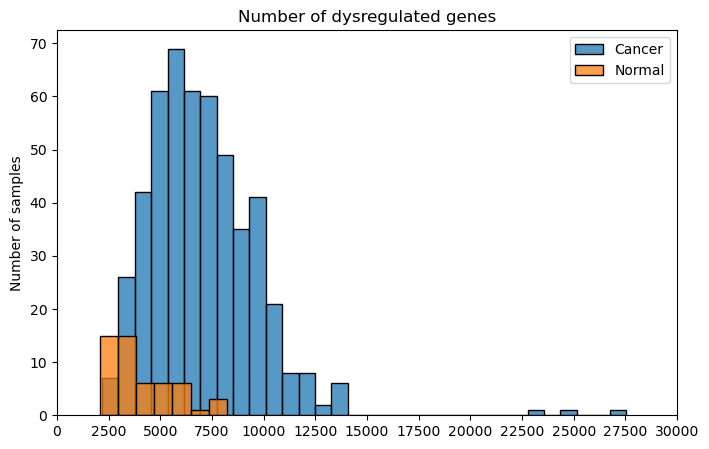

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(dysregulated_cancer.sum(axis=1), label='Cancer')
sns.histplot(dysregulated_normal.sum(axis=1), label='Normal')
plt.title('Number of dysregulated genes')
plt.legend()
plt.xticks(np.arange(0, 30001, 2500))
plt.ylabel('Number of samples')
#plt.savefig('Charts/Dysregulated_genes.pdf')
#plt.yscale('log')
plt.show()

# Minimum graph

In [46]:
min_dysreg_sample_idx = np.argmin(dysregulated_cancer.sum(axis=1))
min_dysreg_nodes = np.where(cancer_sample[min_dysreg_sample_idx, :] > 0)[0]
min_dysreg_nodes

array([   49,    60,    74, ..., 46904, 46915, 46922])

In [47]:
min_Graph = Graph.subgraph(min_dysreg_nodes)
# pos = nx.spring_layout(min_Graph)
#nx.write_gexf(Graph, 'result_files/graph.gexf')
#nx.draw(min_Graph, pos=pos)

# Minimum samples

In [48]:
brownian_normal_sample = brownian_sample[normal_idx, :]
# brownian_normal_sample.sum(axis=1)
br_cl2 = np.where(brownian_normal_sample.sum(axis=1) < 50)[0]
min_normal_arg = np.argmin(normal_sample[br_cl2].sum(axis=1)), 
min_normal = normal_sample[br_cl2][min_normal_arg]

In [86]:
'Total dysregulations in minimal cancer sample ' + str(dysregulated_cancer.sum(axis=1)[np.argmin(cancer_sample.sum(axis=1))])

'Total dysregulations in minimal cancer sample 2182.0'

In [49]:
min_cancer_sample = np.argmin(cancer_sample.sum(axis=1))
min_cancer = cancer_sample[min_cancer_sample, :]
#min_normal_sample = np.argmin(normal_sample.sum(axis=1))

min_cancer_idx = np.where(cancer_sample[min_cancer_sample, :] == 1)[0]
min_normal_idx = np.where(normal_sample[br_cl2][min_normal_arg] == 1)[0]

min_freq_cancer = [frequencies[i] for i in min_cancer_idx]
min_freq_normal = [frequencies[i] for i in min_normal_idx]

min_dgr_cancer = [Graph.degree[i] for i in min_cancer_idx]
min_dgr_normal = [Graph.degree[i] for i in min_normal_idx]      

# common_idx = np.intersect1d(min_cancer_idx, min_normal_idx)
# common_dgr = [Graph.degree[i] for i in common_idx]
# common_frq = [frequencies[i] for i in common_idx]

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
# sns.scatterplot(x=min_freq_cancer, y=min_dgr_cancer, ax=ax1)
# sns.scatterplot(x=min_freq_normal, y=min_dgr_normal, ax=ax2)
# sns.scatterplot(x=common_frq, y=common_dgr, ax=ax3)
# ax1.set_ylabel('Degree')
# ax1.set_xlabel('Frequency')
# ax2.set_xlabel('Frequency')
# ax3.set_xlabel('Frequency')
# ax1.set_title('Cancer')
# ax2.set_title('Normal')
# ax3.set_title(f'Common genes ({common_idx.size})')
# fig.tight_layout()
#plt.savefig('Charts/minimum_samples.pdf')

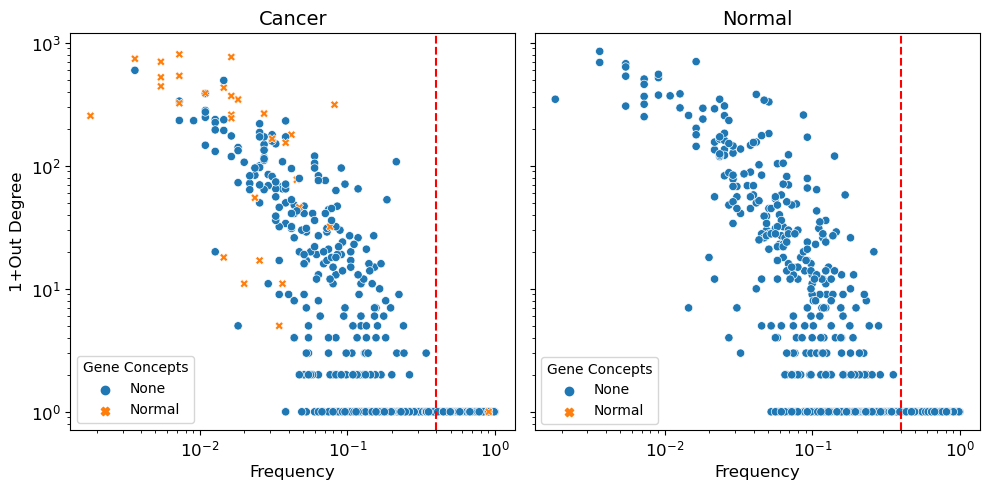

In [50]:
min_odgr_cancer = [Graph.out_degree[i] for i in min_cancer_idx]
min_odgr_normal = [Graph.out_degree[i] for i in min_normal_idx]   

hue_normal = concepts[min_normal_idx]
hue_cancer = concepts[min_cancer_idx]

fs = 12

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
sns.scatterplot(x=min_freq_cancer, y=1 + np.asarray(min_odgr_cancer), ax=ax[0], hue=hue_cancer, style=hue_cancer)
sns.scatterplot(x=min_freq_normal, y=1 + np.asarray(min_odgr_normal), ax=ax[1], hue=hue_normal, legend=False)
ax[0].set_ylabel('1+Out Degree', fontsize=fs)
ax[1].set_xlabel('Frequency', fontsize=fs)
ax[0].set_xlabel('Frequency', fontsize=fs)
ax[0].set_title('Cancer', fontsize=fs + 2)
ax[1].set_title('Normal', fontsize=fs + 2)
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].axvline(0.4, ls='--', c='r')
ax[1].axvline(0.4, ls='--', c='r')

for i in range(2):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

ax[0].legend(title='Gene Concepts')
#ax[1].legend(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.67, 0.29), title='Gene Concepts')
fig.tight_layout()
#plt.savefig('Charts/min_samples_grid_threshold.pdf')

### Number of outdegree genes

In [51]:
min_odgr_cancer = np.array(min_odgr_cancer)
min_odgr_normal = np.array(min_odgr_normal)

print(f'Number of out_degree genes in min_cancer: {(min_odgr_cancer > 0).sum()}')
print(f'Number of out_degree genes in min_normal: {(min_odgr_normal > 0).sum()}')

Number of out_degree genes in min_cancer: 256
Number of out_degree genes in min_normal: 278


### Common outdegree genes

In [52]:
outdgr_canc = min_cancer_idx[np.where(min_odgr_cancer > 0)[0]]
outdgr_norm = min_normal_idx[np.where(min_odgr_normal > 0)[0]]
np.savetxt('result_files/outdegree_commons.txt', np.intersect1d(outdgr_canc, outdgr_norm), fmt='%i')

### Indegree and frequency

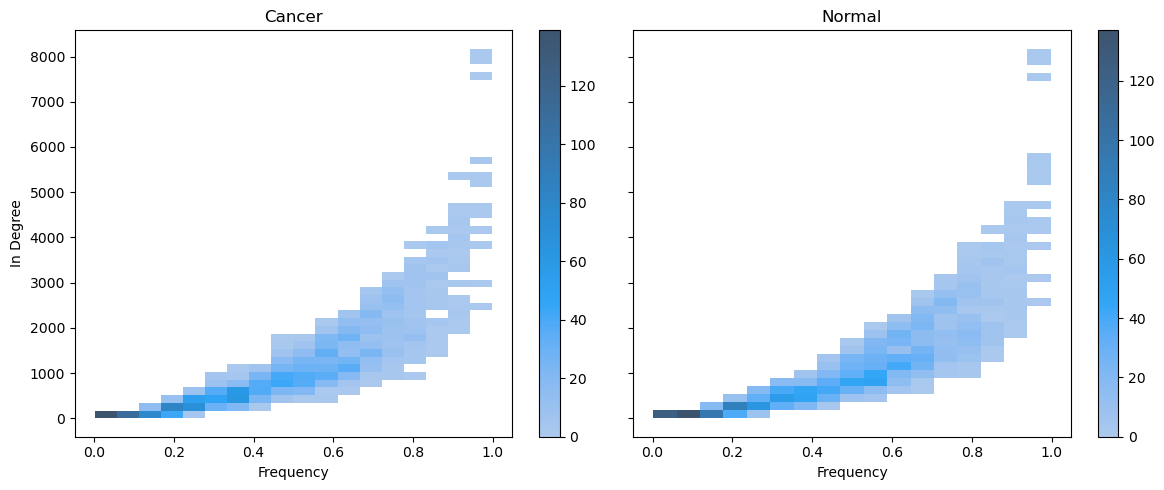

In [53]:
min_idgr_cancer = np.array([Graph.in_degree[i] for i in min_cancer_idx])
min_idgr_normal = np.array([Graph.in_degree[i] for i in min_normal_idx])

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.histplot(y=min_idgr_cancer, x=frequencies[min_cancer_idx], cbar=True, ax=ax[0])
sns.histplot(y=min_idgr_normal, x=frequencies[min_normal_idx], cbar=True, ax=ax[1])
ax[0].set_ylabel('In Degree')
ax[0].set_title('Cancer')
ax[0].set_xlabel('Frequency')
ax[1].set_title('Normal')
ax[1].set_xlabel('Frequency')
fig.tight_layout()
#plt.savefig('Charts/Indgr_freq.pdf')

# Childelss frequencies

In [54]:
childless = [k for k in range(Graph.number_of_nodes()) if Graph.out_degree()[k] == 0]
len(childless)

19460

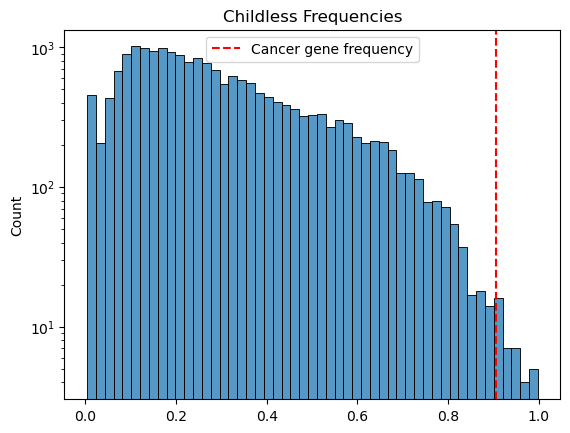

In [55]:
sns.histplot(sample[:, childless].mean(axis=0))
plt.axvline(sample[:, -1].mean(), ls='--', c='r', label='Cancer gene frequency')
plt.yscale('log')
plt.title('Childless Frequencies')
plt.legend()
#plt.savefig('Charts/Childless_frequencies.pdf')

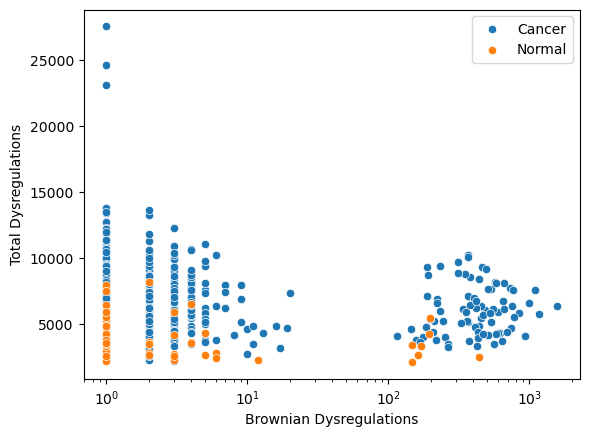

In [56]:
# Plot total dusregulations vs brownian dysregulations
x_c = brownian_cancer_sample.sum(axis=1)
x_n = brownian_sample[normal_idx, :].sum(axis=1)
y_c = dysregulated_cancer.sum(axis=1)
y_n = dysregulated_normal.sum(axis=1)
sns.scatterplot(x=x_c, y=y_c, label='Cancer')
sns.scatterplot(x=x_n, y=y_n, label='Normal')
plt.xlabel('Brownian Dysregulations')
plt.ylabel('Total Dysregulations')
plt.xscale('log')
#plt.savefig('Charts/Dysregulations_scatter_xlog.jpg', dpi=600)

In [57]:
(x_c < 50).sum(), (x_n < 50).sum(), (x_c < 50).sum() + (x_n < 50).sum()

(418, 45, 463)

# Group 2 Intersections

Text(0.5, 1.0, 'Gene coincidences in cluster 2 (88 samples)')

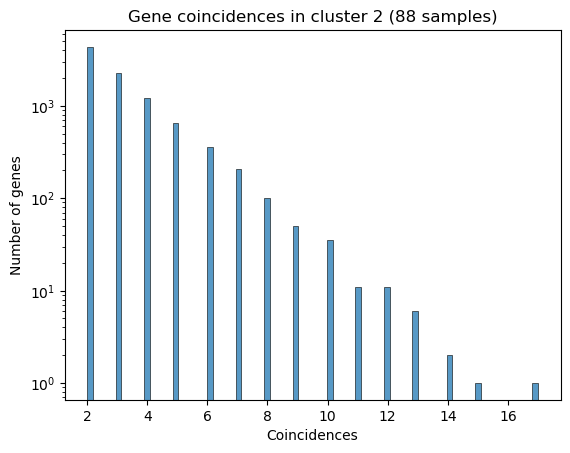

In [58]:
brown_2 = brownian_sample[(brownian_sample.sum(axis=1) > 50), :]
sns.histplot(brown_2.sum(axis=0)[(brown_2.sum(axis=0) > 1)])
plt.yscale('log')
plt.xlabel('Coincidences')
plt.ylabel('Number of genes')
plt.title('Gene coincidences in cluster 2 (88 samples)')
#plt.savefig('Charts/CL2_coincidences.pdf')

# Group 1 degree and dysregulations

In [59]:
with open('result_files/Cluster1.txt', mode='w') as f:
    for i in range(brownian_normal_sample.shape[0]):
        nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
        write = False
        if len(nodes) < 50:
            write = True
            line = f'{dysregulated_normal[i, :].sum().astype(int)}\tNormal\t'
            for node in nodes:
                line = line + str(Graph.out_degree[node]) + '{'
                genes = compressed_nodes_map[node]
                for n, gene in enumerate(genes):
                    if n > 0:
                        line = line + ', '
                    line = line + genes_map[gene]
                line = line + '}\t'
        if write:
            line = line + '\n'
            f.write(line)

    for i in range(brownian_cancer_sample.shape[0]):
        nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
        write = False
        if len(nodes) < 50:
            write = True
            line = f'{dysregulated_cancer[i, :].sum().astype(int)}\tCancer\t'
            for node in nodes:
                line = line + str(Graph.out_degree[node]) + '{'
                genes = compressed_nodes_map[node]
                for n, gene in enumerate(genes):
                    if n > 0:
                        line = line + ', '
                    #print(gene, genes_map[gene])
                    line = line + genes_map[gene]
                line = line + '}\t'
        if write:
            line = line + '\n'
            f.write(line)

### Alternative table

In [60]:
with open('result_files/Cluster1_supplement.csv', mode='w') as f:
    f.write('Total Dysregulations,Sample Type,Altered Brownian Nodes\n')
    for i in range(brownian_normal_sample.shape[0]):
        nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
        write = False
        if len(nodes) < 50:
            write = True
            line = f'{dysregulated_normal[i, :].sum().astype(int)},Normal,'
            for node in nodes:
                line = line + str(node) + ','
        if write:
            line = line + '\n'
            f.write(line)

    for i in range(brownian_cancer_sample.shape[0]):
        nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
        write = False
        if len(nodes) < 50:
            write = True
            line = f'{dysregulated_cancer[i, :].sum().astype(int)},Tumor,'
            for node in nodes:
                line = line + str(node) + ','
        if write:
            line = line + '\n'
            f.write(line)

# Group 2 degree and dysregulations

In [61]:
with open('result_files/Cluster2.txt', mode='w') as f:
    for i in range(brownian_normal_sample.shape[0]):
        nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
        write = False
        if len(nodes) > 50:
            write = True
            line = f'{dysregulated_normal[i, :].sum().astype(int)}\tNormal\t'
            for node in nodes:
                line = line + str(Graph.out_degree[node]) + '{'
                genes = compressed_nodes_map[node]
                for n, gene in enumerate(genes):
                    if n > 0:
                        line = line + ', '
                    line = line + genes_map[gene]
                line = line + '}\t'
        if write:
            line = line + '\n'
            f.write(line)

    for i in range(brownian_cancer_sample.shape[0]):
        nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
        write = False
        if len(nodes) > 50:
            write = True
            line = f'{dysregulated_cancer[i, :].sum().astype(int)}\tCancer\t'
            for node in nodes:
                line = line + str(Graph.out_degree[node]) + '{'
                genes = compressed_nodes_map[node]
                for n, gene in enumerate(genes):
                    if n > 0:
                        line = line + ', '
                    #print(gene, genes_map[gene])
                    line = line + genes_map[gene]
                line = line + '}\t'
        if write:
            line = line + '\n'
            f.write(line)

### Alternative table

In [62]:
with open('result_files/Cluster2_supplement.csv', mode='w') as f:
    f.write('Total Dysregulations,Sample Type,Altered Brownian Nodes\n')

    for i in range(brownian_normal_sample.shape[0]):
        nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
        write = False
        if len(nodes) > 50:
            write = True
            line = f'{dysregulated_normal[i, :].sum().astype(int)},Normal,'
            for node in nodes:
                line = line + str(node) + ','
        if write:
            line = line + '\n'
            f.write(line)

    for i in range(brownian_cancer_sample.shape[0]):
        nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
        write = False
        if len(nodes) > 50:
            write = True
            line = f'{dysregulated_cancer[i, :].sum().astype(int)},Tumor,'
            for node in nodes:
                line = line + str(node) + ','
        if write:
            line = line + '\n'
            f.write(line)

# Coincidences in CL2

In [63]:
# Define samples for each cluster
cl2_idx = (brownian_sample.sum(axis=1) > 50)
cl2_sample = sample[cl2_idx, :]
cl1_idx = (brownian_sample.sum(axis=1) < 50)
cl1_sample = sample[cl1_idx, :]
sample[cl2_idx].mean(axis=0).shape

(46923,)

In [64]:
# Identify hig frequency brownian gene in cl2
cl2_sample = sample[cl2_idx, :]
cl2_brown_max = np.argmax(brown_2.mean(axis=0))
decompresse_cl2_brown_max = compressed_nodes_map[cl2_brown_max]
print(cl2_brown_max, decompresse_cl2_brown_max, genes_map[decompresse_cl2_brown_max[0]])

13785 [15223] KIAA0319L


In [65]:
# Identify Omnipresent gene in cl2
cl2_matches = np.where(cl2_sample.mean(axis=0) == 1)[0]
print(cl2_matches)
cl2_mactch = cl2_matches[0]
cl2_matches.size, cl2_mactch

[19846]


(1, 19846)

In [66]:
decompressed_match = compressed_nodes_map[cl2_mactch]
print(decompressed_match)
genes_map[decompressed_match[0]]

[22055]


'PSPHP1'

In [67]:
# Check frequency in cl1
cl1_sample.mean(axis=0)[cl2_mactch]

0.9978401727861771

In [68]:
# Check frequency in all samples
sample.mean(axis=0)[cl2_mactch] * sample.shape[0], sample.shape[0]

(550.0, 551)

### High frequency genes in CL2

In [70]:
# Identify high frequency genes in cl2
cl2_hfreq_idx = np.where(cl2_sample.mean(axis=0) < 0.4)[0]
cl2_hfreq = [compressed_nodes_map[i] for i in cl2_hfreq_idx]

# with open('result_files/hight_freq_cl2.csv', mode='w') as f:
#     f.write('Frequency, Node, Associated_Gene_Names\n')

#     for idx, elems in zip(cl2_hfreq_idx, cl2_hfreq):
#         line = str(cl2_sample.mean(axis=0)[idx].round(3)) + ',' + str(idx)
#         for elem in elems:
#             line = line + ',' + genes_map[elem]
#         line = line + '\n'
#         f.write(line)

### Scatter by frequency of hfreq cl2

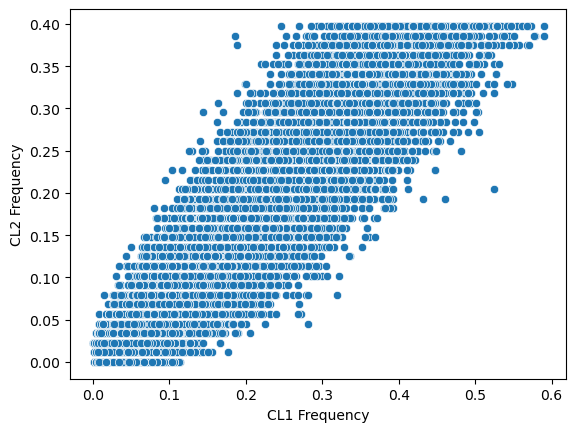

In [71]:
sns.scatterplot(y=cl2_sample.mean(axis=0)[cl2_hfreq_idx], x=cl1_sample.mean(axis=0)[cl2_hfreq_idx])
plt.xlabel('CL1 Frequency')
plt.ylabel('CL2 Frequency')
#plt.savefig('Charts/frequency_clusters.pdf')

# Build frequency and degree table

In [72]:
nodes_idx = np.arange(Graph.number_of_nodes())
freqs = sample.mean(axis=0)
freqs_c = cancer_sample.mean(axis=0)
in_degree = [Graph.in_degree[k] for k in nodes_idx]
out_degree = [Graph.out_degree[k] for k in nodes_idx]

In [73]:
df = pd.DataFrame({'Node': nodes_idx, 'Frequency': freqs,
                  'Frequency_in_cancer': freqs_c, 'In_Degree': in_degree, 'Out_Degree': out_degree})
# df.to_csv('result_files/freq_degree.csv', index=False)

# Build extended table

In [74]:
# Build childs array
associated = [compressed_nodes_map[i] for i in nodes_idx]
associated_genes = []
for elems in associated:
    temp = []
    for elem in elems:
        temp.append(genes_map[elem])
    associated_genes.append(temp)

associated_genes = [str(elem)[1:-1].replace("'", "") for elem in associated_genes]


# Multiplicity
multiplicity = [len(compressed_nodes_map[i]) for i in nodes_idx]

In [75]:
df = pd.DataFrame({'Node': nodes_idx, 'Frequency': freqs.round(4),
                  'Frequency_in_cancer': freqs_c.round(4), 'In_Degree': in_degree, 
                  'Out_Degree': out_degree, 'Multiplicity': multiplicity,
                  'Associated_genes': associated_genes})
#df.to_csv('result_files/nodes.csv', index=False) 